In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
input_csv_file = "./dataset/BTC_USD_Coinbase_day_2023-07-11.csv"
output_model = "saved_BTC_model.h5"

# input_csv_file = "./dataset/ADA_USD_Coinbase_day_2023-07-11.csv"
# output_model = "saved_ADA_model.h5"

# input_csv_file = "./dataset/ETH_USD_Coinbase_day_2023-07-11.csv"
# output_model = "saved_ETH_model.h5"

In [3]:
df=pd.read_csv(input_csv_file)
df.head()

,datetime,low,high,open,close,volumefrom,volumeto
0,2018-01-17,9010.00,12358.89,11570.01,11200.01,60648.02,6.387934e+08
1,2018-01-18,10687.21,12123.10,11200.01,11305.53,29065.20,3.358221e+08
2,2018-01-19,11050.00,11973.99,11305.53,11498.99,15569.99,1.784998e+08
3,2018-01-20,11498.99,12985.55,11498.99,12762.80,18087.06,2.242529e+08
4,2018-01-21,11118.00,12762.80,12762.80,11518.16,15537.70,1.837634e+08


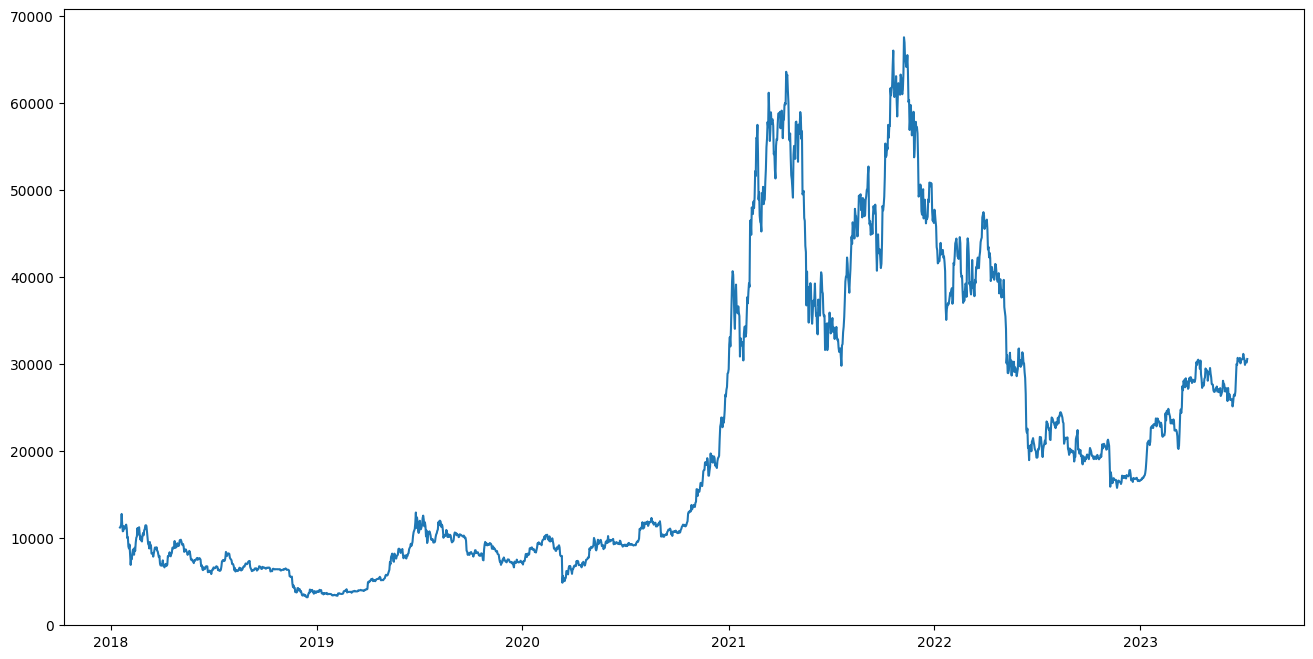

In [4]:
df["datetime"]=pd.to_datetime(df.datetime,format="%Y-%m-%d")
df.index=df['datetime']
plt.figure(figsize=(16,8))
plt.plot(df["close"],label='Close Price history')

In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['datetime','close'])
for i in range(0,len(data)):
    new_dataset["datetime"][i]=data['datetime'][i]
    new_dataset["close"][i]=data["close"][i]

In [6]:
test_size = 0.3
split_row = len(df) - int(test_size * len(df))

In [7]:
new_dataset.index=new_dataset.datetime
new_dataset.drop("datetime",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:split_row,:]
valid_data=final_dataset[split_row:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [8]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1341/1341 - 31s - loss: 0.0033 - 31s/epoch - 23ms/step


In [9]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

19/19 [==============================] - 1s 18ms/step


In [10]:
lstm_model.save(output_model)

C:\Users\lonel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\lonel\AppData\Local\Temp\ipykernel_17440\1070846319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['predictions']=predicted_closing_price


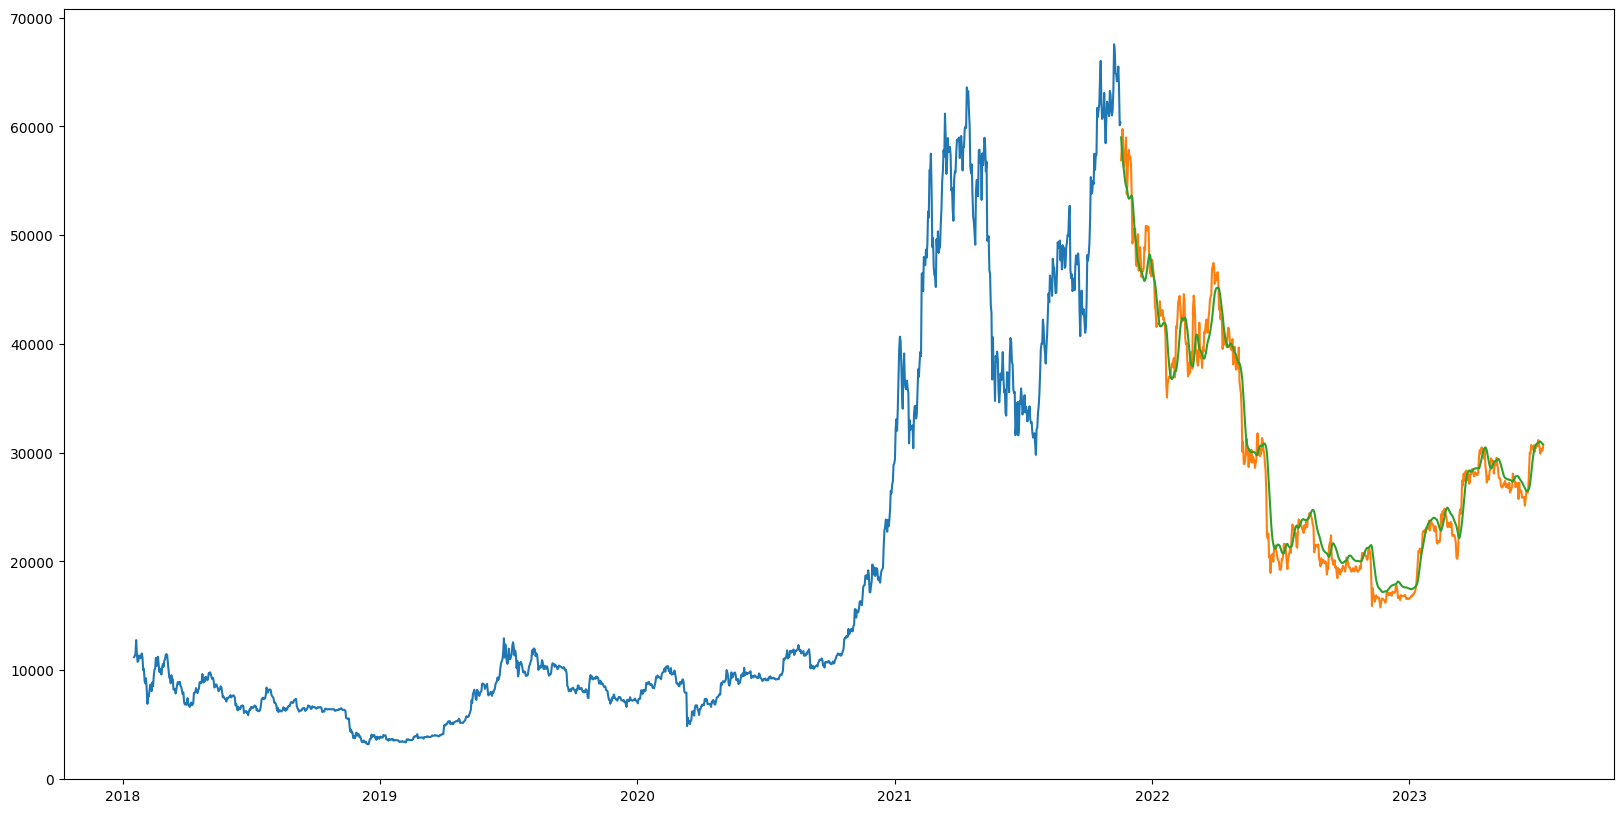

In [11]:
train_data=new_dataset[:split_row]
valid_data=new_dataset[split_row:]
valid_data['predictions']=predicted_closing_price
plt.plot(train_data["close"])
plt.plot(valid_data[['close',"predictions"]])